In [1]:
import numpy as np
import pandas as pd
from DG_classes import *
from DiffusionGeometry import *
import matplotlib.pyplot as plt
from DG_ml_stats import *
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.subplots as subplots

from sklearn import manifold, decomposition
import plotly.express as px

from data_loader import *
from visualisation import *
import os

Import the cell data.

In [2]:
n_CD8 = 65
CD8 = []
for sample in range(1,1+n_CD8):
    df = pd.read_csv(f"./data/ExampleSmallSamples/PointClouds/TumourT_CCD810NNCodensitySample{sample}RipsMax1.txt")[3:]
    string_vals = df.values.flatten().astype('<U30')
    split_strings = np.char.split(string_vals)
    vals = np.array([np.array(coords).astype(float) for coords in split_strings])
    CD8.append(vals[:,:2])

n_CD68 = 73
CD68 = []
for sample in range(1,1+n_CD68):
    df = pd.read_csv(f"./data/ExampleSmallSamples/PointClouds/TumourT_CCD6810NNCodensitySample{sample}RipsMax1.txt")[3:]
    string_vals = df.values.flatten().astype('<U30')
    split_strings = np.char.split(string_vals)
    vals = np.array([np.array(coords).astype(float) for coords in split_strings])
    CD68.append(vals[:,:2])

n_FoxP3 = 74
FoxP3 = []
for sample in range(1,1+n_FoxP3):
    df = pd.read_csv(f"./data/ExampleSmallSamples/PointClouds/TumourT_CFoxP310NNCodensitySample{sample}RipsMax1.txt")[3:]
    string_vals = df.values.flatten().astype('<U30')
    split_strings = np.char.split(string_vals)
    vals = np.array([np.array(coords).astype(float) for coords in split_strings])
    FoxP3.append(vals[:,:2])

In [3]:
all_raw_data = []
for cell_type in ['CD8', 'CD68', 'FoxP3']:

    directory = os.listdir('./data/1.5mmRegions/{}/'.format(cell_type))
    directory.sort()
    directory = np.array(directory)

    sample_indices = np.array([l for l in np.char.split(directory, '_')])[:,[1,3]]
    tumour_letters = np.unique(sample_indices[:,0])

    cell_data = []
    for letter in tumour_letters:
        samples = []
        sample_nbrs = sample_indices[sample_indices[:,0] == letter,1].astype(int)
        sample_nbrs.sort()
        for nbr in sample_nbrs:
            samples.append(pd.read_csv("./data/1.5mmRegions/{}/T_{}_ROI_{}_locations_{}.csv".format(cell_type,letter,nbr,cell_type)).values)
        cell_data.append(samples)
    
    all_raw_data.append(cell_data)

all_CD8, all_CD68, all_FoxP3 = all_raw_data

Test parameters by plotting the eigenforms and eigenfunctions of the Laplacian.

[0.85317 1.64162] 0.8531697528586363


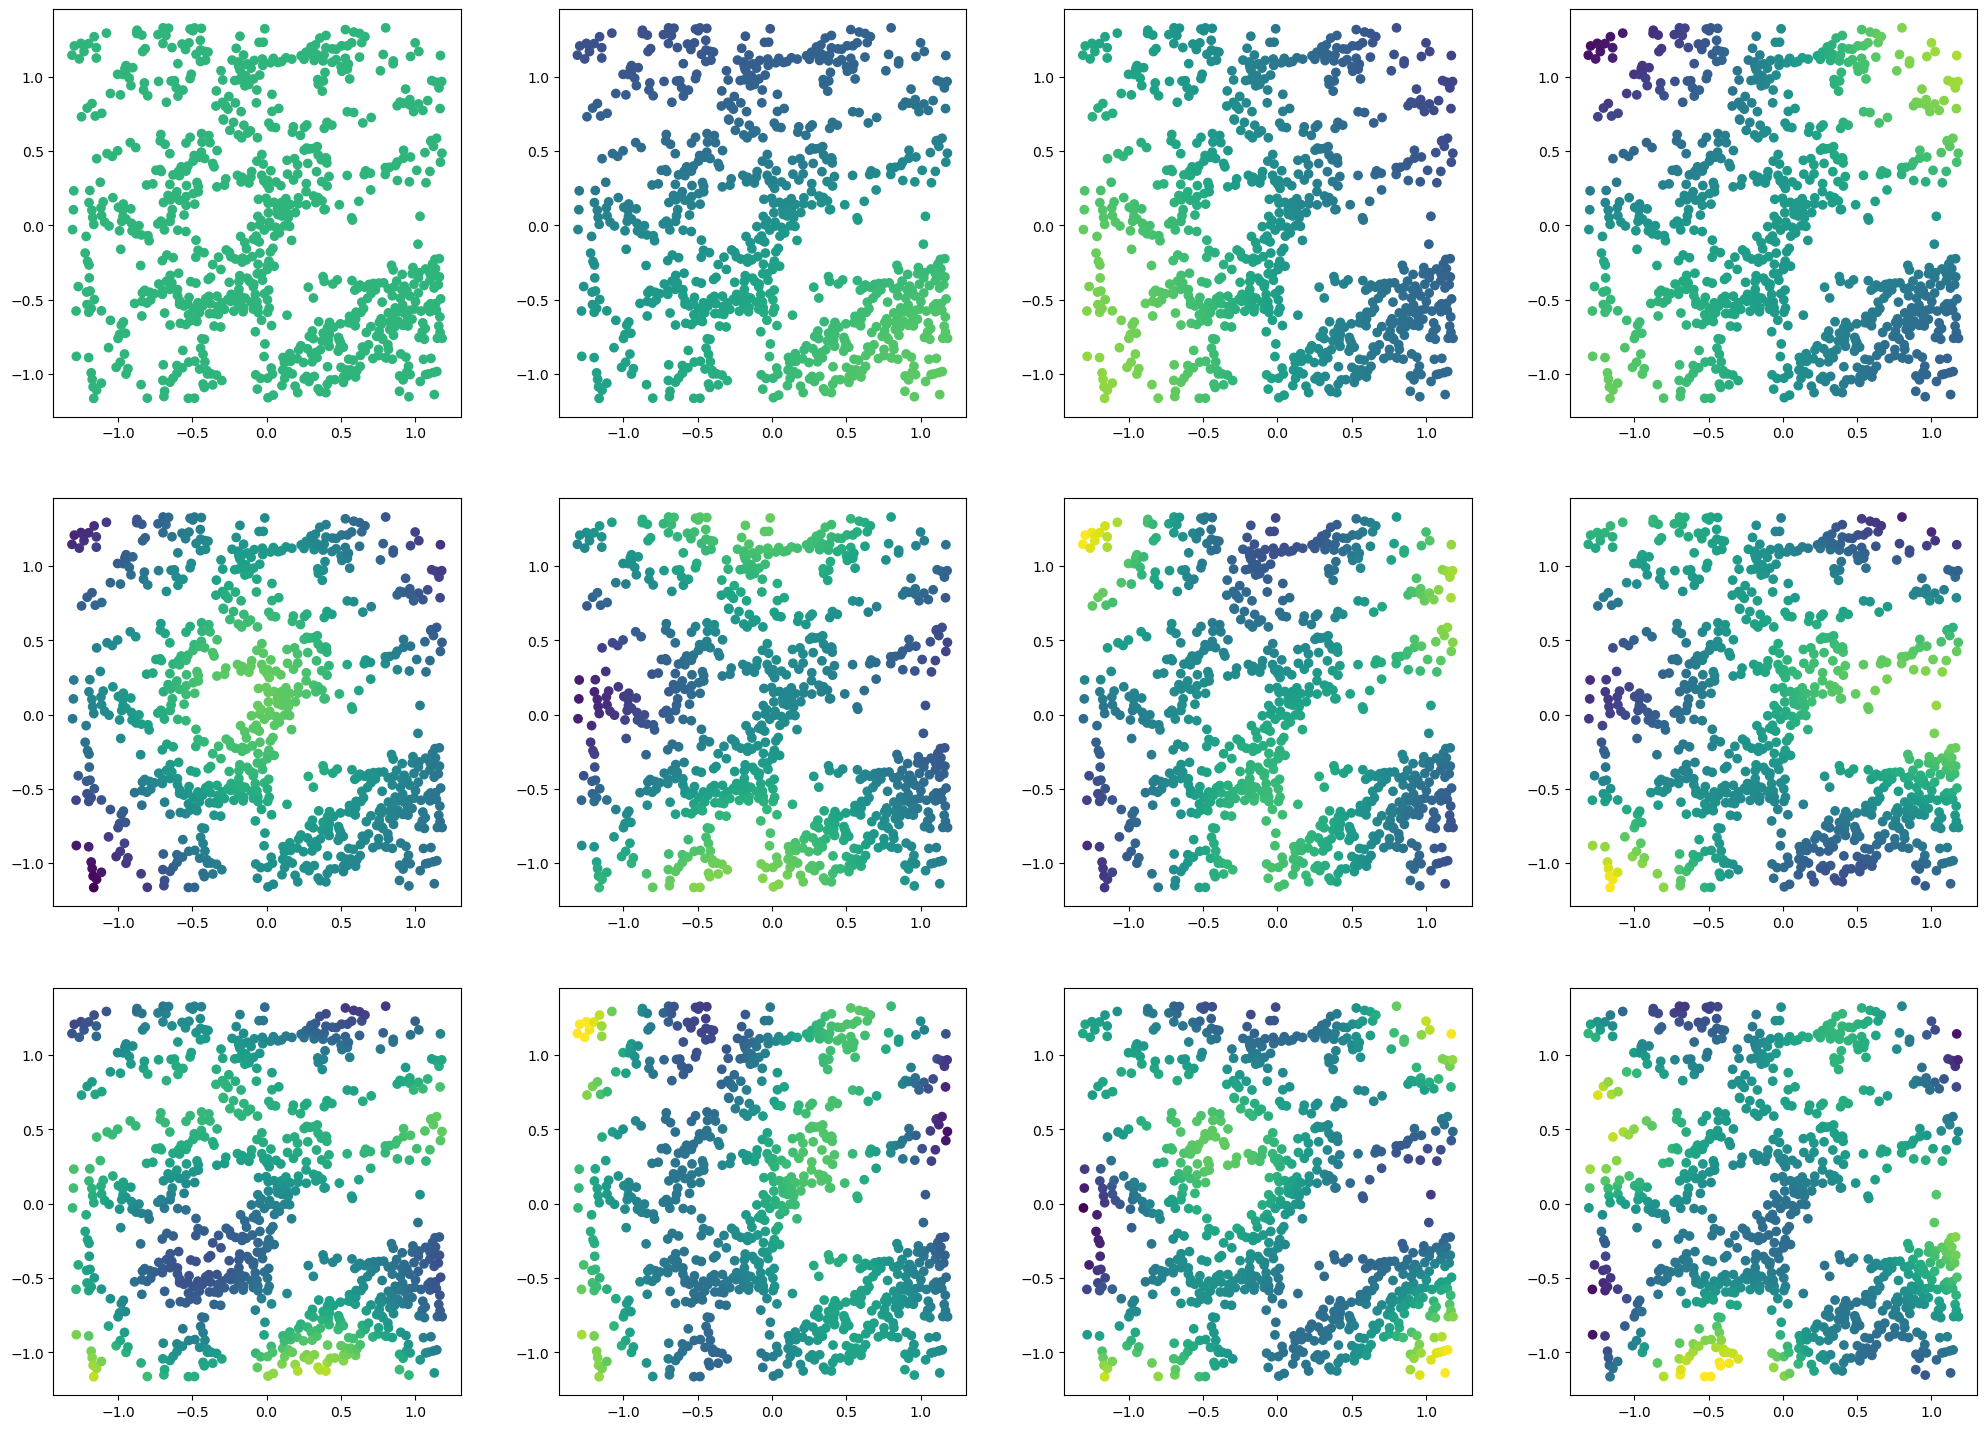

In [20]:
X = CD8[3]

parameters = {}
parameters['n0'] = 30
parameters['n1'] = 16
parameters['n2'] = 4
parameters['ep'] = 0.4
parameters['alpha'] = 0.8
parameters['projection_tol'] = 1e-3

DG_class = DG(X, parameters)
DG_class.plot_eigenfunctions(3,4)

L1, U1 = DG_class.weak_eigenproblem_1(DG_class.D1())
data = DG_class.data
k = 0
v = U1[:,k]
print(L1[:2].round(6), L1[k])

plot_quiver_plain_tight(v, DG_class)

## Compute diffusion geometry for all point clouds

In [21]:
from sklearn import linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
numbers = [n_CD8, n_CD68, n_FoxP3]

In [22]:
limits = {}
limits['eigenfunctions'] = 5
limits['1-eigenforms-div'] = 2
limits['1-eigenforms-curl'] = 4
limits['use curvature'] = False
limits['metric expansion'] = 5
limits['divergence-only threshold'] = 0.5

parameters = {}
parameters['n0'] = 30
parameters['n1'] = 12
parameters['n2'] = 4
parameters['projection_tol'] = 1e-3

numbers = [n_CD8, n_CD68, n_FoxP3]
param_test_data = []
for ep in [0.4,0.5,0.6,0.7,0.8]:
    for alpha in [0,0.1,0.2,0.5,0.8]:
        print('Testing epsilon = {}, alpha = {}'.format(ep,alpha))

        # Setup parameters
        parameters['ep'] = ep
        parameters['alpha'] = alpha

        # Compute features
        try:
            dg_features = compute_dg_features(parameters, limits, [CD8, CD68, FoxP3])
        except:
            continue
        norm_dg_features = norm_features(dg_features)

        # Cross-validate model for each cell type pair and regularisation parameter
        for cells in [(0,1),(0,2),(1,2)]:
        # for cells in [(0,1)]:
            cell1, cell2 = cells
            pair_features = np.concatenate((norm_dg_features[cell1],norm_dg_features[cell2]))
            y = np.array([0]*numbers[cell1] + [1]*numbers[cell2])
            for regularisation in [0.07,0.1,0.5,1,5]:
                clf = linear_model.LogisticRegression(penalty='l1', solver = 'liblinear', C = regularisation)
                CV_mean, CV_std, CV_feats_mean, CV_feats_std = cross_validate_model(clf, pair_features, y, cell1, cell2, numbers, runs=100)
                param_test_data.append([ep,alpha,cells,regularisation,CV_mean,CV_std,CV_feats_mean,CV_feats_std])
            pair_data = []
            for reg in param_test_data[-4:]:
                pair_data.append(reg[4:])
            pair_data = np.array(pair_data)
            print('cell type pair', cells, (np.array([100,100,1,1])*pair_data[np.argmax(pair_data[:,0])]).round(2))

param_test_df = pd.DataFrame(param_test_data, columns=['ep','alpha','cell pair','reg','acc mean','acc std','features mean','features std'])

Testing epsilon = 0.4, alpha = 0
cell type pair (0, 1) [56.21  7.83 79.47  6.12]
cell type pair (0, 2) [82.32  5.81 25.89  8.08]
cell type pair (1, 2) [ 89.47   5.33 186.95  22.66]
Testing epsilon = 0.4, alpha = 0.1
cell type pair (0, 1) [54.43  8.42 82.9   6.24]
cell type pair (0, 2) [ 84.32   6.   211.65  24.58]
cell type pair (1, 2) [ 90.07   5.44 177.81  17.64]
Testing epsilon = 0.4, alpha = 0.2
cell type pair (0, 1) [55.79  8.8  82.6   6.86]
cell type pair (0, 2) [ 82.54   6.33 226.32  23.19]
cell type pair (1, 2) [ 88.5    4.48 100.85  14.23]
Testing epsilon = 0.4, alpha = 0.5
cell type pair (0, 1) [54.75  9.69 88.    7.65]
cell type pair (0, 2) [85.    6.6  21.38  7.36]
cell type pair (1, 2) [ 88.87   5.36 197.57  18.47]
Testing epsilon = 0.4, alpha = 0.8
cell type pair (0, 1) [57.82  6.99 27.19  3.57]
cell type pair (0, 2) [81.82  6.47 45.36 10.93]
cell type pair (1, 2) [ 87.93   5.22 108.16   9.5 ]
Testing epsilon = 0.5, alpha = 0
cell type pair (0, 1) [47.89  7.27 81.88  6.18

In [24]:
param_test_df

,ep,alpha,cell pair,reg,acc mean,acc std,features mean,features std
0,0.4,0.0,"(0, 1)",0.07,0.488214,0.085125,8.29,1.996472
1,0.4,0.0,"(0, 1)",0.10,0.522857,0.086532,25.87,3.562738
2,0.4,0.0,"(0, 1)",0.50,0.562143,0.078347,79.47,6.121201
3,0.4,0.0,"(0, 1)",1.00,0.547500,0.086168,92.58,7.190522
4,0.4,0.0,"(0, 1)",5.00,0.554286,0.076178,147.52,13.933758
...,...,...,...,...,...,...,...,...
370,0.8,0.8,"(1, 2)",0.07,0.874667,0.059837,16.64,5.948983
371,0.8,0.8,"(1, 2)",0.10,0.889333,0.049862,33.85,7.563564
372,0.8,0.8,"(1, 2)",0.50,0.872000,0.057100,106.17,9.542594
373,0.8,0.8,"(1, 2)",1.00,0.884667,0.058389,140.23,10.943359


In [109]:
param_test_df.to_csv('params_test_cell_classficiation_1')

In [110]:
max_reg = pd.DataFrame(param_test_df.iloc[:,[0,1,2,4]].values.reshape(-1,5,4).max(axis=1), columns=['ep','alpha','cell pair','acc mean'])

pair = (1,2)
pair_data = max_reg[max_reg['cell pair'] == pair].iloc[:,[0,1,3]]
pair_data

fig = px.scatter(x=pair_data['ep'], y=pair_data['alpha'], color = pair_data['acc mean'].astype(float), color_continuous_scale='inferno')
fig.update_traces(marker={'size': 40})
fig.update_layout(
    xaxis_title="epsilon", yaxis_title="alpha"
)

In [162]:
limits = {}
limits['eigenfunctions'] = 5
limits['1-eigenforms-div'] = 2
limits['1-eigenforms-curl'] = 4
limits['use curvature'] = False
limits['metric expansion'] = 5
limits['divergence-only threshold'] = 0.5

parameters = {}
parameters['n0'] = 30
parameters['n1'] = 12
parameters['n2'] = 4
parameters['projection_tol'] = 1e-3

test_2_features = []

for pair in [(0,1),(0,2),(1,2)]:
    print('\n',pair)
    cell_pair_data = param_test_df[param_test_df['cell pair'] == pair]
    highest_acc_indices = np.argsort(cell_pair_data['acc mean'].values)[::-1]
    best_params = cell_pair_data.iloc[highest_acc_indices[:10]]
    best_params = list(set(zip(best_params['ep'],best_params['alpha'])))[:4]

    # Compute and save features for the best parameters
    pair_features = []
    for ep, alpha in best_params:
        print('Computing epsilon = {}, alpha = {}'.format(ep,alpha))

        # Setup parameters
        parameters['ep'] = ep
        parameters['alpha'] = alpha

        # Compute features
        dg_features = compute_dg_features(parameters, limits, [CD8, CD68, FoxP3])
        norm_dg_features = norm_features(dg_features)

        # Save features
        pair_features.append(norm_dg_features)    
    
    test_2_features.append(pair_features)


 (0, 1)
Testing epsilon = 0.8, alpha = 0.8


In [ ]:
limits = {}
limits['eigenfunctions'] = 5
limits['1-eigenforms-div'] = 2
limits['1-eigenforms-curl'] = 4
limits['use curvature'] = False
limits['metric expansion'] = 5
limits['divergence-only threshold'] = 0.5

parameters = {}
parameters['n0'] = 30
parameters['n1'] = 12
parameters['n2'] = 4
parameters['projection_tol'] = 1e-3

numbers = [n_CD8, n_CD68, n_FoxP3]
param_test_data = []
for ep in [0.4,0.5,0.6,0.7,0.8]:
    for alpha in [0,0.1,0.2,0.5,0.8]:
        print('Testing epsilon = {}, alpha = {}'.format(ep,alpha))

        # Setup parameters
        parameters['ep'] = ep
        parameters['alpha'] = alpha

        # Compute features
        try:
            dg_features = compute_dg_features(parameters, limits, [CD8, CD68, FoxP3])
        except:
            continue
        norm_dg_features = norm_features(dg_features)

        # Cross-validate model for each cell type pair and regularisation parameter
        for cells in [(0,1),(0,2),(1,2)]:
        # for cells in [(0,1)]:
            cell1, cell2 = cells
            pair_features = np.concatenate((norm_dg_features[cell1],norm_dg_features[cell2]))
            y = np.array([0]*numbers[cell1] + [1]*numbers[cell2])
            for regularisation in [0.07,0.1,0.5,1,5]:
                clf = linear_model.LogisticRegression(penalty='l1', solver = 'liblinear', C = regularisation)
                CV_mean, CV_std, CV_feats_mean, CV_feats_std = cross_validate_model(clf, pair_features, y, cell1, cell2, numbers, runs=100)
                param_test_data.append([ep,alpha,cells,regularisation,CV_mean,CV_std,CV_feats_mean,CV_feats_std])
            pair_data = []
            for reg in param_test_data[-4:]:
                pair_data.append(reg[4:])
            pair_data = np.array(pair_data)
            print('cell type pair', cells, (np.array([100,100,1,1])*pair_data[np.argmax(pair_data[:,0])]).round(2))

param_test_df = pd.DataFrame(param_test_data, columns=['ep','alpha','cell pair','reg','acc mean','acc std','features mean','features std'])

In [132]:
# all_tests_df = pd.concat((param_test_df,param_test_df1))

best_results = param_test_df[['ep','alpha','acc mean']].groupby(['ep','alpha']).max()
best_results = best_results.reset_index()

# pair = (0,1)
# pair_data = best_results[best_results['cell pair'] == pair].iloc[:,[0,1,3]]
pair_data = best_results

fig = px.scatter(x=pair_data['ep'], y=pair_data['alpha'], color = pair_data['acc mean'].astype(float), color_continuous_scale='inferno')
fig.update_traces(marker={'size': 40})
fig.update_layout(
    xaxis_title="epsilon", yaxis_title="alpha"
)

In [133]:
best_results

,ep,alpha,acc mean
0,0.4,0.0,0.894667
1,0.4,0.1,0.900667
2,0.4,0.2,0.885000
3,0.4,0.5,0.888667
4,0.4,0.8,0.879333
5,0.5,0.0,0.873333
6,0.5,0.1,0.857333
7,0.5,0.2,0.866333
8,0.5,0.5,0.877000
9,0.5,0.8,0.873000


In [259]:
# all_tests_df.to_csv('data/ExampleSmallSamples/tests_df.csv')

param_test_df = pd.read_csv('data/ExampleSmallSamples/balanced_tests_df.csv')
best_results = param_test_df[['ep','alpha','acc mean']].groupby(['ep','alpha']).max()
best_results = best_results.reset_index()
max_reg = pd.DataFrame(param_test_df.iloc[:,1:5].values.reshape(-1,5,4).max(axis=1), columns=['ep','alpha','cell pair','acc mean'])

pair = (0,2)
pair_data = max_reg[max_reg['cell pair'] == str(pair)]#.iloc[:,[0,1,3]]
# pair_data
fig = px.scatter(x=pair_data['ep'], y=pair_data['alpha'], color = pair_data['acc mean'].astype(float), color_continuous_scale='inferno')
fig.update_traces(marker={'size': 40})
fig.update_layout(
    xaxis_title="epsilon", yaxis_title="alpha"
)


In [253]:
param_test_df[(param_test_df['cell pair']==str((0,1))) * (param_test_df['ep']==0.4) * (param_test_df['alpha']==0.2)]

,Unnamed: 0,ep,alpha,cell pair,acc mean,acc std,features mean,features std,reg
330,30,0.4,0.2,"(0, 1)",0.552821,0.090291,13.16,2.440164,0.07
331,31,0.4,0.2,"(0, 1)",0.569615,0.087711,29.88,3.998200,0.10
332,32,0.4,0.2,"(0, 1)",0.602949,0.074722,79.19,5.615505,0.50
333,33,0.4,0.2,"(0, 1)",0.597615,0.090864,90.51,7.229793,1.00
334,34,0.4,0.2,"(0, 1)",0.597821,0.097014,132.39,10.044795,5.00


In [112]:
from DG_ml_stats import *

In [251]:
limits = {}
limits['eigenfunctions'] = 5
limits['1-eigenforms-div'] = 2
limits['1-eigenforms-curl'] = 4
limits['use curvature'] = False
limits['metric expansion'] = 5
limits['divergence-only threshold'] = 0.5

parameters = {}
parameters['n0'] = 30
parameters['n1'] = 16
parameters['n2'] = 4
parameters['projection_tol'] = 1e-3

parameters['ep'] = 0.8
parameters['alpha'] = 0.8
dg_features1 = compute_dg_features(parameters, limits, [CD8, CD68, FoxP3])
print(dg_features1[0][0].shape)

parameters['ep'] = 1.5
parameters['alpha'] = 1
dg_features2 = compute_dg_features(parameters, limits, [CD8, CD68, FoxP3])
print(dg_features2[0][0].shape)

dg_features = [np.concatenate((dg_features1[0], dg_features2[0]), axis = 1),
               np.concatenate((dg_features1[1], dg_features2[1]), axis = 1),
               np.concatenate((dg_features1[2], dg_features2[2]), axis = 1)]
print(dg_features[0][0].shape)
norm_dg_features = norm_features(dg_features)
print(norm_dg_features[0][0].shape)

(38744,)
(38744,)
(77488,)
(59021,)


In [257]:
cell1 = 1
cell2 = 2
# pca = decomposition.PCA(n_components=50)

pair_features = np.concatenate((norm_dg_features[cell1],norm_dg_features[cell2]))

y = np.array([0]*numbers[cell1] + [1]*numbers[cell2])

features = pair_features
# features = reduced_features
test_data = []
# for regularisation in [0.06,0.07,0.08,0.09,0.10]:
for regularisation in [0.07,0.1,0.3,0.6,1]:
    clf = linear_model.LogisticRegression(penalty='l1', solver = 'liblinear', C = regularisation)
    # clf = LinearDiscriminantAnalysis()
    CV_mean, CV_std, CV_feats_mean, CV_feats_std = cross_validate_model(clf, features, y, cell1, cell2, numbers, runs=100)
    test_data.append([regularisation,CV_mean,CV_std,CV_feats_mean,CV_feats_std])
    print(regularisation, ':', (100*CV_mean).round(2), (100*CV_std).round(2), CV_feats_mean.round(2))

0.07 : 88.3 5.3 7.65
0.1 : 90.0 5.64 14.85
0.3 : 89.83 4.68 43.97
0.6 : 90.1 3.96 64.01
1 : 89.43 4.22 81.84


In [254]:
limits = {}
limits['eigenfunctions'] = 5
limits['1-eigenforms-div'] = 2
limits['1-eigenforms-curl'] = 4
limits['use curvature'] = False
limits['metric expansion'] = 5
limits['divergence-only threshold'] = 0.5

parameters = {}
parameters['n0'] = 30
parameters['n1'] = 16
parameters['n2'] = 4
parameters['projection_tol'] = 1e-3
parameters['ep'] = 0.4
parameters['alpha'] = 0.2

dg_features = compute_dg_features(parameters, limits, [CD8, CD68, FoxP3])
norm_dg_features = norm_features(dg_features)

cell1 = 0
cell2 = 1
# pca = decomposition.PCA(n_components=50)

pair_features = np.concatenate((norm_dg_features[cell1],norm_dg_features[cell2]))

y = np.array([0]*numbers[cell1] + [1]*numbers[cell2])

features = pair_features
# features = reduced_features
test_data = []
# for regularisation in [0.06,0.07,0.08,0.09,0.10]:
for regularisation in [0.07,0.1,0.3,0.6,1]:
    clf = linear_model.LogisticRegression(penalty='l1', solver = 'liblinear', C = regularisation)
    # clf = LinearDiscriminantAnalysis()
    CV_mean, CV_std, CV_feats_mean, CV_feats_std = cross_validate_model(clf, features, y, cell1, cell2, numbers, runs=100)
    test_data.append([regularisation,CV_mean,CV_std,CV_feats_mean,CV_feats_std])
    print(regularisation, ':', (100*CV_mean).round(2), (100*CV_std).round(2), CV_feats_mean.round(2))

0.07 : 46.64 8.14 12.39
0.1 : 45.96 8.64 31.9
0.3 : 48.11 7.9 74.76
0.6 : 49.89 8.17 88.79
1 : 48.96 8.52 97.82
